## Importación de las librerías

In [14]:
import utils
import pickle
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

En este notebook se llevará a cabo una validación cruzada repetida con todos los modelos ganadores para posteriormente seleccionar uno de ellos como el **modelo final**.

Además, dicha validación cruzada será lleveada a cabo teniendo en cuenta todos los datos es decir train y test, ya que el objetivo de esta parte es la selección del mejor modelo

## Conjuntos de entrenamiento y test y CV controller

In [2]:
X_train, X_test, y_train, y_test = utils.get_train_test_data()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7776, 12) (1022, 12) (7776,) (1022,)


Juntamos train y test en X e Y

In [79]:
X = X_train.append(X_test)
X.reset_index(inplace=True, drop=True)

Y = pd.concat([y_train, y_test])
Y.reset_index(inplace=True, drop=True)

In [82]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=99)
cv

RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=99)

## Carga de los modelos

In [83]:
models = []
models.append(('Logistic Regression', pickle.load(open('/kaggle/input/logistic-regression-model/logistic_regression_model.sav', 'rb'))))
models.append(('Decision Tree', pickle.load(open('/kaggle/input/decision-tree-model/decision_tree_model.sav', 'rb'))))
models.append(('Bagging Decision Tree', pickle.load(open('/kaggle/input/bagging-with-decision-tree-model/bagging_tree_model.sav', 'rb'))))
models.append(('Bagging Logistic Regression', pickle.load(open('/kaggle/input/bagging-with-logistic-regression/bagging_log_reg_model.sav', 'rb'))))
models.append(('Random Forest', pickle.load(open('/kaggle/input/random-forest-model/random_forest_model.sav', 'rb'))))
models.append(('Gradient Boosting', pickle.load(open('/kaggle/input/gradient-boosting-model/gradient_boosting_model.sav', 'rb'))))
models.append(('XGBoosting', pickle.load(open('/kaggle/input/xgboost-model/xgboosting_model.sav', 'rb'))))
models.append(('Support Vector Classifier', pickle.load(open('/kaggle/input/svm-model/svc_lineal_model.sav', 'rb'))))
models.append(('Neural Network', pickle.load(open('/kaggle/input/neural-network-model/nn_model.sav', 'rb'))))
models.append(('Stacking', pickle.load(open('/kaggle/input/stacking-model/stacking_model.sav', 'rb'))))
models

[('Logistic Regression',
  LogisticRegression(C=0.5, random_state=99, solver='saga')),
 ('Decision Tree',
  DecisionTreeClassifier(max_depth=10, min_samples_leaf=45, min_samples_split=200,
                         random_state=99)),
 ('Bagging Decision Tree',
  BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                          min_samples_leaf=45,
                                                          min_samples_split=200,
                                                          random_state=99),
                    max_samples=0.6, random_state=99)),
 ('Bagging Logistic Regression',
  BaggingClassifier(base_estimator=LogisticRegression(C=0.5, random_state=99,
                                                      solver='saga'),
                    max_samples=0.3, random_state=99)),
 ('Random Forest',
  RandomForestClassifier(max_depth=10, max_features='sqrt', max_samples=0.6,
                         min_samples_leaf=4

Función que representa los boxplots tras la validación cruzada repetida

In [84]:
def boxplots_algorithms(results_df):
    fig, ax = plt.subplots(figsize=(20,10))
    ax = sns.boxplot(data=results_df, x='model', y='roc_auc', orient='v')
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

In [85]:
results = []
names = []

for model_name, model in models:
    score = cross_val_score(model, X, Y, cv=cv,
                            scoring='roc_auc', n_jobs=-1, verbose=0)
    results.append(score)
    names.append(model_name)

A primera vista se pueden descartar los siguientes modelos debido a su roc_auc bajo:
- **Logistic Regression**
- **Bagging Logistic Regression**
- **Support Vector Classifier**
- **Neural Network**

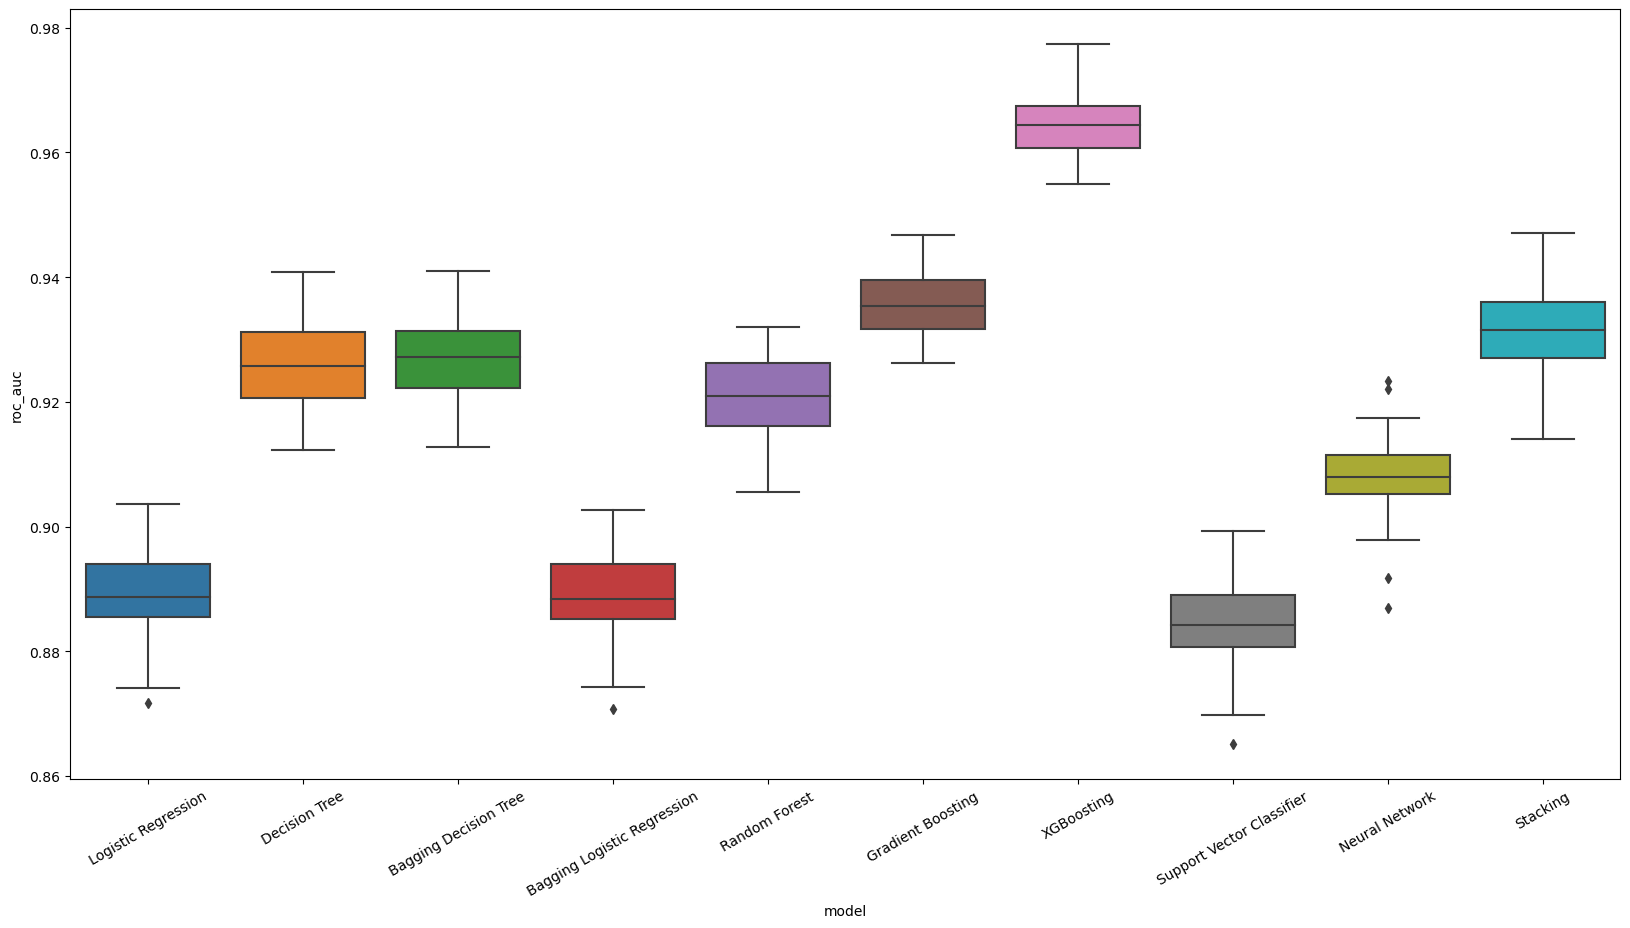

In [86]:
repeated_names = np.repeat(names,50)
results_flatten = [res2 for res1 in results for res2 in res1]
results_df = pd.DataFrame(list(zip(repeated_names, results_flatten)), columns=['model', 'roc_auc'])
boxplots_algorithms(results_df)

También se puede descartar el **Decision Tree** ya que su varianza parece ser mayor que la de los modelos restantes.

Como modelo final se selecciona el **GradientBoosting** ya que es quién menor varianza posee y además es el segundo modelo con el mayor roc_auc en media

In [97]:
result_subset_df = results_df[
    (results_df.model == 'Decision Tree') | (results_df.model == 'Bagging Decision Tree') |
    (results_df.model == 'Random Forest') | (results_df.model == 'Gradient Boosting') |
    (results_df.model == 'XGBoosting') | (results_df.model == 'Stacking')
]
result_subset_df\
.groupby(['model'])['roc_auc']\
.describe()\
.drop(columns=['count', '25%', '75%','50%', 'min', 'max'])\
.sort_values('mean', ascending=False)

,mean,std
model,,
XGBoosting,0.964258,0.005393
Gradient Boosting,0.935581,0.004917
Stacking,0.931371,0.006825
Bagging Decision Tree,0.927002,0.006680
Decision Tree,0.926055,0.007315
Random Forest,0.920990,0.006135
